<a href="https://colab.research.google.com/github/Taketo-Muroya/Nowcasting-Project/blob/main/Colab/nowcast-4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The nowcasting of economic conditions in Japan using ML

2022/01/18　打ち合わせメモ

*   経済マクロデータを変数に含める（所得、エネルギー・食料・サービス価格、金利、インフレ期待、株価の先行き、感染者数）
*   見せかけの相関が疑われるので、(1,1,0)のARIMAが望ましいのでは。
*   コロナ前のデータとコロナ後で分ける見せ方、説明の仕方も良いかもしれない。

## Setting Up

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#import os
#os.chdir('drive/MyDrive/Colab Notebooks/Economic-Nowcasting-in-Japan')

In [ ]:
pip install pytrends

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import packages
import re
import os
import sys
import requests
#import MeCab
#import oseti
#import urllib
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf

from math import sqrt
from bs4 import BeautifulSoup
from pathlib import Path
from subprocess import call
from keras.regularizers import l2
from statsmodels.tsa.seasonal import seasonal_decompose

from nltk.corpus import stopwords as sw       
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    # add current dataset
    indices = range(i-history_size, i+1, step)
    temp = pd.DataFrame(dataset[indices])
    # replace current target to previous one
    temp.iat[history_size, 0] = temp.iat[history_size-1, 0]
    data.append(np.array(temp))

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
def model_eval_metrics(y_true, y_pred, classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

## Target variable: Indexes of Business Conditions (IBC)

The Index of Business Conditions (IBC) represents monthly economic conditions in Japan. This study uses either coincident index (level) or coincident ann (change from the previouse year: Year-over-Year) as a target variable.

In [ ]:
from bs4 import BeautifulSoup
import requests

url = 'https://www.esri.cao.go.jp/jp/stat/di/'
url_index = url + 'di.html'
res = requests.get(url_index)
soup = BeautifulSoup(res.text, 'html.parser')

name = soup.find_all('a', {'target': '_blank'})[2].attrs['href']
input_file_name = url + name
input_file_name

'https://www.esri.cao.go.jp/jp/stat/di/0805ci.xlsx'

In [ ]:
#xls book Open (xls, xlsxのどちらでも可能)
input_book = pd.ExcelFile(input_file_name)
#sheet_namesメソッドでExcelブック内の各シートの名前をリストで取得できる
input_sheet_name = input_book.sheet_names
#lenでシートの総数を確認
num_sheet = len(input_sheet_name)
#シートの数とシートの名前のリストの表示
print ("Sheet の数:", num_sheet)
print (input_sheet_name)

Sheet の数: 1
['指数 Indexes']


In [ ]:
#DataFrameとしてsheet1枚のデータを読込み
input_sheet_df = input_book.parse(input_sheet_name[0], skiprows=3)
input_sheet_df = input_sheet_df.iloc[62:,[0,4]]
input_sheet_df = input_sheet_df.rename(columns={'Time (Monthly) Code':'time'})
input_sheet_df['time'] = input_sheet_df['time'].astype('int')
#input_sheet_df['time'] = input_sheet_df['time'].replace('00','')
input_sheet_df

,time,Coincident Index
62,1985000101,79
63,1985000202,78.7
64,1985000303,78.6
65,1985000404,79.5
66,1985000505,79.5
...,...,...
507,2022000202,96.3
508,2022000303,96.8
509,2022000404,96.8
510,2022000505,94.9


In [ ]:
ibc = input_sheet_df.astype('float')
#ibc = pd.read_csv('data/ibc_new.csv')
ibc['Coincident ann'] = 100*ibc['Coincident Index'].pct_change(12)

## Google Trend

Use google trend information as predictors

### Google Trend API

In [ ]:
# Import packages
from pytrends.request import TrendReq
plt.rcParams['font.family'] = 'IPAexGothic'

# API Connection
pytrends = TrendReq(hl='ja-JP', tz=360)

Correlation of level: -0.86
Correlation of YoY: -0.77


Text(0.5, 1.0, 'Google Search: "Unemployment"')

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


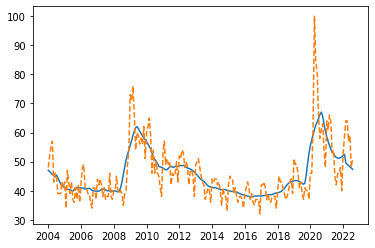

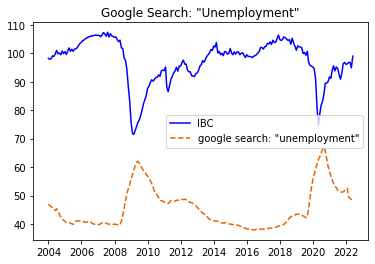

In [ ]:
# Set keyword ("失業" = "unemployment")
kw1 = "失業"
kw_list1 = [kw1]
pytrends.build_payload(kw_list1, timeframe='all', geo='JP')
gt1 = pytrends.interest_over_time()
gt1 = gt1.rename(columns = {kw1:"var1", "isPartial":"info"})
#gt1.to_csv("data/gt1.csv")
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#gt1 = pd.read_csv('data/gt1.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s1 = seasonal_decompose(gt1.iloc[:,0], extrapolate_trend='freq')
t1 = s1.trend
#data1 = pd.merge(gt1.iloc[:,0], t1, on='date')
plt.plot(t1)
plt.plot(gt1.iloc[:,0], linestyle='--')

# Check correlation
level = ibc['Coincident Index'][228:]
level.index = t1[:len(ibc)-228].index
cor = level.corr(t1[:len(ibc)-228])
print("Correlation of level: {:.2f}".format(cor))

a1 = gt1.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][228:]
ann.index = a1[:len(ibc)-228].index
cor = ann.corr(a1[:len(ibc)-228])
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t1[:len(ibc)-228].index, ibc['Coincident Index'][228:], linestyle='-', color='b', label='IBC')
ax.plot(t1[:len(ibc)-228].index, t1[:len(ibc)-228], linestyle='--', color='#e46409', label='google search: "unemployment"')
ax.legend()
plt.title('Google Search: "Unemployment"')
#plt.savefig("images/google1.png")

Correlation of level: 0.39
Correlation of YoY: 0.21


Text(0.5, 1.0, 'Google Search: "Saving"')

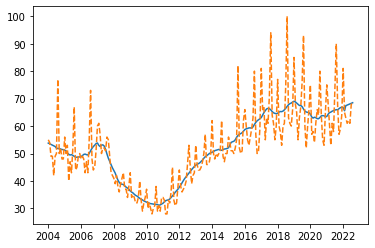

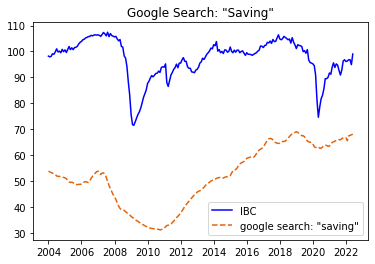

In [ ]:
# Set keyword ("貯金" = "saving")
kw2 = "貯金"
kw_list2 = [kw2]
pytrends.build_payload(kw_list2, timeframe='all', geo='JP')
gt2 = pytrends.interest_over_time()
gt2 = gt2.rename(columns = {kw2:"var2", "isPartial":"info"})
#gt2.to_csv("data/gt2.csv")
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#gt2 = pd.read_csv('data/gt2.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s2 = seasonal_decompose(gt2.iloc[:,0], extrapolate_trend='freq')
t2 = s2.trend
plt.plot(t2)
plt.plot(gt2.iloc[:,0], linestyle='--')

# Check correlation
level = ibc['Coincident Index'][228:]
level.index = t2[:len(ibc)-228].index
cor = level.corr(t2[:len(ibc)-228])
print("Correlation of level: {:.2f}".format(cor))

a2 = gt2.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][228:]
ann.index = a2[:len(ibc)-228].index
cor = ann.corr(a2[:len(ibc)-228])
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t2[:len(ibc)-228].index, ibc['Coincident Index'][228:], linestyle='-', color='b', label='IBC')
ax.plot(t2[:len(ibc)-228].index, t2[:len(ibc)-228], linestyle='--', color='#e46409', label='google search: "saving"')
ax.legend()
plt.title('Google Search: "Saving"')
#plt.savefig("images/google2.png")

In [ ]:
# Combine google trend (level)
gtrend_l = pd.concat([t1, t2], axis=1)

# Combine google trend (YoY)
gtrend_y = pd.concat([a1, a2], axis=1).rename(columns={'var1': 'var1_rate', 'var2': 'var2_rate'})
#gtrend_y = gtrend_y.drop(gtrend_y.index[0:12])

### Time series analysis

In [ ]:
# Set time series dataset
X = pd.merge(gtrend_l, gtrend_y, on='date')
y = ibc[228:]
y = y.set_index('time')
y.index = X[:len(ibc)-228].index
ts = pd.merge(y, X, on='date')

# Split data into training and test set
sp = round(0.8*len(ts))
train = ts[0:sp]
test = ts[sp:]

ts

,Coincident Index,Coincident ann,var1,var2,var1_rate,var2_rate
date,,,,,,
2004-01-01,98.2,8.508287,46.999417,53.797543,NaN,NaN
2004-02-01,97.9,7.346491,46.543852,53.549145,NaN,NaN
2004-03-01,98.1,7.802198,46.088287,53.300748,NaN,NaN
2004-04-01,99.1,9.502762,45.632721,53.052350,NaN,NaN
2004-05-01,98.9,8.324206,45.177156,52.803953,NaN,NaN
...,...,...,...,...,...,...
2022-02-01,96.3,5.592105,52.541667,65.583333,-0.032787,-0.044118
2022-03-01,96.8,3.198294,49.525981,67.422883,-0.030303,0.032787
2022-04-01,96.8,1.255230,49.087315,67.638063,0.000000,0.150943


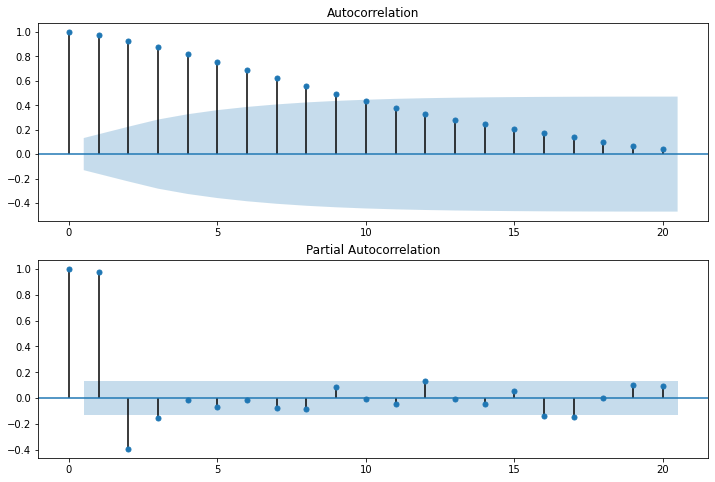

In [ ]:
# Check Autocorrelation of IBC
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts['Coincident Index'], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts['Coincident Index'], lags=20, ax=ax2)
#plt.savefig("images/autocorrelation.png")

In [ ]:
# Unit root test of y (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['Coincident Index'])
print("Unit root test (y): {:.2f}".format(adf_result[1])) # p-value

# Take difference of y
diff = ts['Coincident Index'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_y): {:.2f}".format(adf_result[1])) # p-value

# Unit root test of X (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['var1'])
print("Unit root test (X): {:.2f}".format(adf_result[1])) # p-value

# Take difference of X
diff = ts['var1'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_X): {:.2f}".format(adf_result[1])) # p-value

# Cointegration test (H0: non-cointegration)
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['var1'])
print("Cointegration test (var1): {:.2f}".format(coint_result[1])) # p-value
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['var2'])
print("Cointegration test (var2): {:.2f}".format(coint_result[1])) # p-value

Unit root test (y): 0.07
Unit root test (diff_y): 0.00
Unit root test (X): 0.05
Unit root test (diff_X): 0.05
Cointegration test (var1): 0.23
Cointegration test (var2): 0.13


### ARIMA Prediction

In [ ]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident Index'], train.iloc[:,2:4], order=(1,1,0), freq='MS').fit()
print(SARIMAX.summary())

                           Statespace Model Results                           
Dep. Variable:       Coincident Index   No. Observations:                  178
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -302.579
Date:                Mon, 08 Aug 2022   AIC                            613.157
Time:                        05:44:34   BIC                            625.862
Sample:                    01-01-2004   HQIC                           618.310
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
var1          -0.8769      0.161     -5.462      0.000      -1.192      -0.562
var2           0.1448      0.267      0.542      0.588      -0.379       0.669
ar.L1          0.1419      0.067      2.112      0.0

Test set score: 0.59


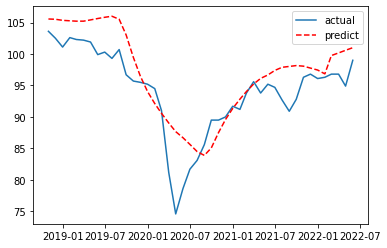

In [ ]:
pred = SARIMAX.predict(test.index[0], test.index[-1], exog=test.iloc[:,2:4])
plt.plot(test['Coincident Index'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')

print("Test set score: {:.2f}".format(r2_score(test['Coincident Index'], pred)))

### Random Forest

Training set score: 1.00
Cross-Validation score: 0.59
Test set score: 0.74


Text(0.5, 1.0, 'Random Forest: Level')

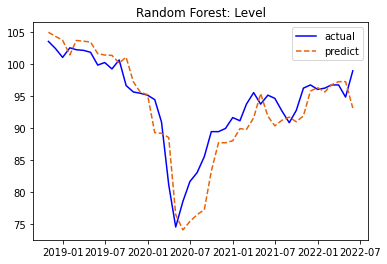

In [ ]:
# Set X and y variables
X = ts.iloc[:,2:4]
y = ts['Coincident Index']

# Preprocess for adding AR
X_l = X.drop(X.index[0])
#X_l = X_l.drop(X_l.index[0])
X_l.reset_index(inplace=True, drop=True)

# Generate AR variable
y_l = y.drop(y.index[-1])
#y_l = y_l.drop(y_l.index[-1])
y_l.reset_index(inplace=True, drop=True)

# Add AR into X
X_t = pd.concat([y_l, X_l], axis=1)
y_t = y.drop(y.index[0])
#y_t = y_t.drop(y_t.index[0])
X_t.index = y_t.index

# Split data into training and test set 
sp = round(0.8*len(X_t))
X_train = X_t[0:sp]
X_test = X_t[sp:]
y_train = y_t[0:sp]
y_test = y_t[sp:]

# Fit the model
tm = RandomForestRegressor(n_estimators=1000).fit(X_train, y_train)
#tm.feature_importances_

# Goodness of Fit
print("Training set score: {:.2f}".format(tm.score(X_train, y_train)))
print("Cross-Validation score: {:.2f}".format(
          np.mean(cross_val_score(tm, X_train, y_train, cv=5))))
print("Test set score: {:.2f}".format(tm.score(X_test, y_test)))

# Calculate the prediction
prediction = pd.DataFrame(tm.predict(X_test))
pre = prediction.values.tolist()
act = y_test.values.tolist()
predict = pd.DataFrame(pre, columns=['predict'])
actual = pd.DataFrame(act, columns=['actual'])
com = pd.concat([predict, actual], axis=1)

# Plot the prediction
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(X_test.index, com.actual, linestyle='-', color='b', label='actual')
ax.plot(X_test.index, com.predict, linestyle='--', color='#e46409', label='predict')
ax.legend(loc='best')
ax.set_title('Random Forest: Level')
#plt.savefig("images/google_rf.png")

In [ ]:
print(tm.feature_importances_)

[0.90564611 0.06641635 0.02793755]


### RNN-LSTM

In [ ]:
# set the dataset
features = pd.concat([ts['Coincident Index'], ts.iloc[:,2:4]], axis=1)
features.tail()

,Coincident Index,var1,var2
date,,,
2022-02-01,96.3,52.541667,65.583333
2022-03-01,96.8,49.525981,67.422883
2022-04-01,96.8,49.087315,67.638063
2022-05-01,94.9,48.648650,67.853244
2022-06-01,99.0,48.209984,68.068425


In [ ]:
# set training percentage
TRAIN_SPLIT = round(0.8*len(features))
print(TRAIN_SPLIT)

# feature scaling
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

178


In [ ]:
# create the training and test data

past_history = 3
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)

In [ ]:
pd.DataFrame(dataset).head(7)

,0,1,2
0,0.005785,0.524502,0.505891
1,-0.033822,0.447582,0.482050
2,-0.007417,0.370662,0.458210
3,0.124608,0.293742,0.434370
4,0.098203,0.216822,0.410530
5,0.217025,0.139903,0.386689
6,0.375456,0.250227,0.329370


In [ ]:
pd.DataFrame(x_train_single[0])

,0,1,2
0,0.005785,0.524502,0.505891
1,-0.033822,0.447582,0.482050
2,-0.007417,0.370662,0.458210
3,-0.007417,0.293742,0.434370


In [ ]:
y_train_single[0]

0.1246079114419977

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
# construct the model

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(8, input_shape=x_train_single.shape[-2:]))
#single_step_model.add(tf.keras.layers.LSTM(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#single_step_model.add(tf.keras.layers.LSTM(8, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#single_step_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4)))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='mae')

In [ ]:
# train the model
single_step_history = single_step_model.fit(train_data_single, epochs=30, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

Epoch 1/30
200/200 [==============================] - 7s 13ms/step - loss: 0.4680 - val_loss: 1.0484
Epoch 2/30
200/200 [==============================] - 1s 6ms/step - loss: 0.3867 - val_loss: 1.0402
Epoch 3/30
200/200 [==============================] - 1s 6ms/step - loss: 0.3426 - val_loss: 0.9757
Epoch 4/30
200/200 [==============================] - 1s 7ms/step - loss: 0.3098 - val_loss: 0.9044
Epoch 5/30
200/200 [==============================] - 1s 6ms/step - loss: 0.2858 - val_loss: 0.8165
Epoch 6/30
200/200 [==============================] - 1s 6ms/step - loss: 0.2619 - val_loss: 0.7447
Epoch 7/30
200/200 [==============================] - 1s 6ms/step - loss: 0.2414 - val_loss: 0.6863
Epoch 8/30
200/200 [==============================] - 1s 6ms/step - loss: 0.2222 - val_loss: 0.6398
Epoch 9/30
200/200 [==============================] - 1s 6ms/step - loss: 0.2040 - val_loss: 0.5989
Epoch 10/30
200/200 [==============================] - 1s 4ms/step - loss: 0.1892 - val_loss: 0.556

In [ ]:
# evaluate the model
model_eval_metrics(y_val_single, single_step_model.predict(x_val_single), classification="FALSE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0,0,0,0,0.259769,0.509675,0.408062,0.641698


Test set score: 0.64


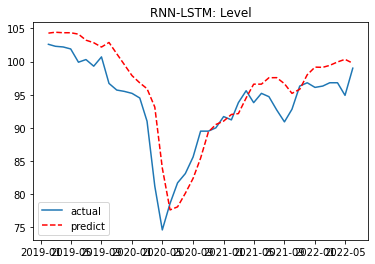

In [ ]:
# visualize the result

predict = pd.DataFrame(single_step_model.predict(x_val_single)*data_std[0]+data_mean[0])
predict.index = features.iloc[TRAIN_SPLIT+past_history:,:].index

actual = pd.DataFrame(y_val_single*data_std[0]+data_mean[0])
actual.index = features.iloc[TRAIN_SPLIT+past_history:,:].index

plt.plot(features.iloc[TRAIN_SPLIT+past_history:,0], label="actual")
plt.plot(predict, "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: Level')
#plt.savefig("images/google_lstm.png")

print("Test set score: {:.2f}".format(r2_score(y_val_single, single_step_model.predict(x_val_single))))


### Weekly Nowcasting

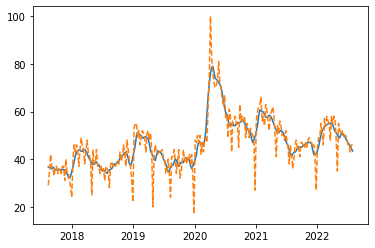

In [ ]:
# Get the weekly google trend data (unemployment)
pytrends.build_payload(kw_list1, timeframe='today 5-y', geo='JP')
#pytrends.build_payload(kw_list, timeframe='2017-01-01 2021-01-16', geo='JP')
gt3 = pytrends.interest_over_time()
gt3 = gt3.rename(columns = {kw1: "var1", "isPartial": "info"})
#gt3.to_csv("data/gt3.csv")
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#gt3 = pd.read_csv('data/gt3.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s3 = seasonal_decompose(gt3.iloc[:,0], freq=6, extrapolate_trend='freq')
t3 = s3.trend
#gtw_u = pd.DataFrame(t3)
#gtw_u.to_csv("data/gtw_u.csv")

plt.plot(t3)
plt.plot(gt3.iloc[:,0], linestyle='--')

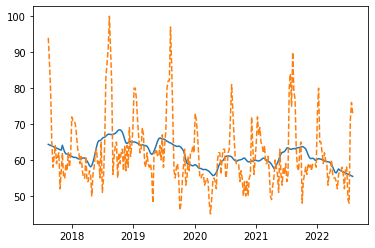

In [ ]:
# Get the weekly google trend data (saving)
pytrends.build_payload(kw_list2, timeframe='today 5-y', geo='JP')
#pytrends.build_payload(kw_list, timeframe='2004-01-01 2020-02-29', geo='JP')
gt4 = pytrends.interest_over_time()
gt4 = gt4.rename(columns = {kw2: "var2", "isPartial": "info"})
#gt4.to_csv("data/gt4.csv")
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#gt4 = pd.read_csv('data/gt4.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s4 = seasonal_decompose(gt4.iloc[:,0], freq=24, extrapolate_trend='freq')
t4 = s4.trend
#gtw_s = pd.DataFrame(t4)
#gtw_s.to_csv("data/gtw_s.csv")

plt.plot(t4)
plt.plot(gt4.iloc[:,0], linestyle='--')

In [ ]:
temp1 = ts
temp1['monthly'] = ts.index.year.astype('str') + '-' + ts.index.month.astype('str')
temp1

,Coincident Index,Coincident ann,var1,var2,var1_rate,var2_rate,monthly
date,,,,,,,
2004-01-01,98.2,8.508287,46.999417,53.797543,NaN,NaN,2004-1
2004-02-01,97.9,7.346491,46.543852,53.549145,NaN,NaN,2004-2
2004-03-01,98.1,7.802198,46.088287,53.300748,NaN,NaN,2004-3
2004-04-01,99.1,9.502762,45.632721,53.052350,NaN,NaN,2004-4
2004-05-01,98.9,8.324206,45.177156,52.803953,NaN,NaN,2004-5
...,...,...,...,...,...,...,...
2022-02-01,96.3,5.592105,52.541667,65.583333,-0.032787,-0.044118,2022-2
2022-03-01,96.8,3.198294,49.525981,67.422883,-0.030303,0.032787,2022-3
2022-04-01,96.8,1.255230,49.087315,67.638063,0.000000,0.150943,2022-4


In [ ]:
temp2 = pd.merge(t3, t4, on='date')
temp2['monthly'] = temp2.index.year.astype('str') + '-' + temp2.index.month.astype('str')
temp2

,var1,var2,monthly
date,,,
2017-08-13,36.726190,64.343774,2017-8
2017-08-20,36.571429,64.196573,2017-8
2017-08-27,36.416667,64.049372,2017-8
2017-09-03,35.833333,63.902171,2017-9
2017-09-10,36.666667,63.754970,2017-9
...,...,...,...
2022-07-03,46.833333,56.078508,2022-7
2022-07-10,46.166667,55.920202,2022-7
2022-07-17,45.161905,55.761896,2022-7


In [ ]:
temp3 = temp1.reset_index().set_index('monthly')
temp4 = temp2.reset_index().set_index('monthly')
temp5 = pd.merge(temp3, temp4, on='monthly', how='right')
temp5

,date_x,Coincident Index,Coincident ann,var1_x,var2_x,var1_rate,var2_rate,date_y,var1_y,var2_y
monthly,,,,,,,,,,
2017-8,2017-08-01,104.6,5.125628,38.625,65.916667,0.028571,0.175000,2017-08-13,36.726190,64.343774
2017-8,2017-08-01,104.6,5.125628,38.625,65.916667,0.028571,0.175000,2017-08-20,36.571429,64.196573
2017-8,2017-08-01,104.6,5.125628,38.625,65.916667,0.028571,0.175000,2017-08-27,36.416667,64.049372
2017-9,2017-09-01,103.8,3.696304,38.750,65.291667,0.027027,0.122807,2017-09-03,35.833333,63.902171
2017-9,2017-09-01,103.8,3.696304,38.750,65.291667,0.027027,0.122807,2017-09-10,36.666667,63.754970
...,...,...,...,...,...,...,...,...,...,...
2022-7,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-03,46.833333,56.078508
2022-7,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-10,46.166667,55.920202
2022-7,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-17,45.161905,55.761896


In [ ]:
XX = temp5[['date_y','Coincident Index','var1_y','var2_y']].set_index('date_y')
XX

,Coincident Index,var1_y,var2_y
date_y,,,
2017-08-13,104.6,36.726190,64.343774
2017-08-20,104.6,36.571429,64.196573
2017-08-27,104.6,36.416667,64.049372
2017-09-03,103.8,35.833333,63.902171
2017-09-10,103.8,36.666667,63.754970
...,...,...,...
2022-07-03,NaN,46.833333,56.078508
2022-07-10,NaN,46.166667,55.920202
2022-07-17,NaN,45.161905,55.761896


In [ ]:
# load the weekly ibc data
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#wibc = pd.read_csv('data/wibc.csv', index_col=0, date_parser=dateparse, dtype='float')

# merge google trend with ibc data
#temp = pd.merge(t3, t4, on='date')
#XX = pd.merge(wibc, temp, on='date')
#XX

Text(0.5, 1.0, 'RNN-LSTM: weekly')

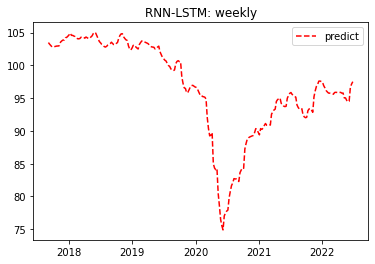

In [ ]:
# feature scaling
END = len(XX)-XX['Coincident Index'].isnull().sum()
dataset = XX.iloc[:END,:].values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

# create the test data
x_single, y_single = multivariate_data(dataset, dataset[:,0], 0, None, past_history, future_target, STEP, single_step=True)

# save the output
past_estimate = pd.DataFrame(single_step_model.predict(x_single)*data_std[0]+data_mean[0])
past_estimate.index = XX.iloc[past_history:END,:].index

# visualize the result 
plt.plot(past_estimate, "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: weekly')
#plt.savefig("images/google_lstm.png")


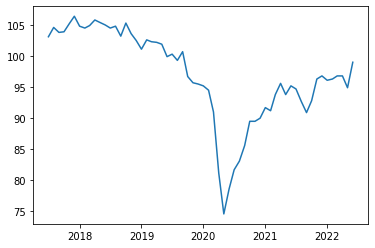

In [ ]:
# compare to IBC graph
plt.plot(ts.iloc[len(ts)-5*12:,0:1])

In [ ]:
# nowcast the future IBC
for i in range(END, len(XX)):
  XX.iat[i,0] = float(single_step_model.predict(x_single)[-1]*data_std[0]+data_mean[0])
  #XX.iat[i,0] = XX.iat[i-1,0]
  temp = XX.iloc[:i+1,:]
  print(temp.tail())
  print('-----------------------------------------------')

  # feature scaling
  dataset = temp.values
  data_mean = dataset.mean(axis=0)
  data_std = dataset.std(axis=0)
  dataset = (dataset-data_mean)/data_std
  
  # create the test data
  x_single, y_single = multivariate_data(dataset, dataset[:,0], 0, None, past_history, future_target, STEP, single_step=True)

  XX.iat[i,0] = float(single_step_model.predict(x_single)[-1]*data_std[0]+data_mean[0])
  print(XX.tail(10))
  print('-----------------------------------------------')

# save the output
future_estimate = pd.DataFrame(XX.iloc[END:len(XX)+1,0])

            Coincident Index     var1_y     var2_y
date_y                                            
2022-06-05         99.000000  50.416667  56.711733
2022-06-12         99.000000  49.750000  56.553427
2022-06-19         99.000000  48.750000  56.395121
2022-06-26         99.000000  47.666667  56.236815
2022-07-03         97.516922  46.833333  56.078508
-----------------------------------------------
            Coincident Index     var1_y     var2_y
date_y                                            
2022-05-29         94.900000  51.083333  56.870039
2022-06-05         99.000000  50.416667  56.711733
2022-06-12         99.000000  49.750000  56.553427
2022-06-19         99.000000  48.750000  56.395121
2022-06-26         99.000000  47.666667  56.236815
2022-07-03         97.632462  46.833333  56.078508
2022-07-10               NaN  46.166667  55.920202
2022-07-17               NaN  45.161905  55.761896
2022-07-24               NaN  44.290476  55.603590
2022-07-31               NaN  43.4

Text(0.5, 1.0, 'RNN-LSTM: weekly + nowcast')

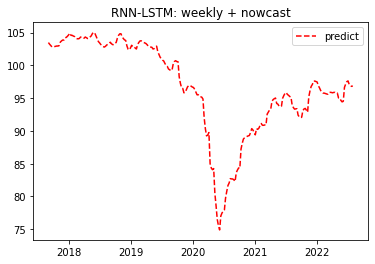

In [ ]:
#plt.plot(single_step_model.predict(x_single)*data_std[0]+data_mean[0], "r", linestyle='--', label="predict")

df_concat = pd.concat([past_estimate.set_axis(['Coincident Index'], axis='columns'), future_estimate])
plt.plot(df_concat, "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: weekly + nowcast')
#plt.savefig("images/google_lstm.png")

In [ ]:
#ibc_latest = pd.read_csv('data/ibc_latest.csv')
#ibc_latest

# compare to IBC graph
#plt.plot(ibc_latest['Coincident Index'][390:])